Open positions saved to open_positions.csv


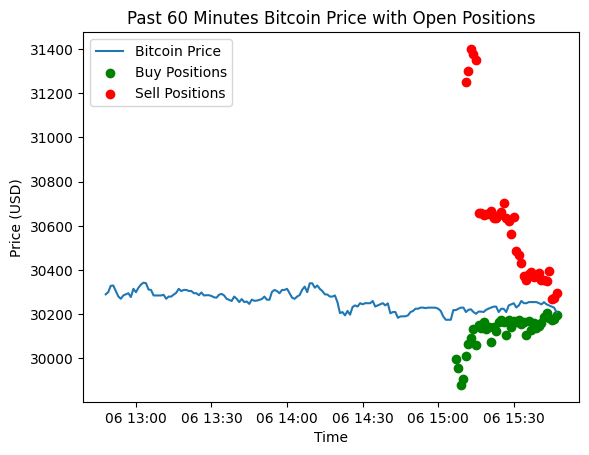

Number of open positions:  78
Number of buy positions:  41
Number of sell positions:  37
Total risk of open positions: $ 7.757959299999997


In [801]:
# plot open positions
# code ran on 12:15 midnight, target 12 midnight to catch all positions

import csv
import datetime
import matplotlib.pyplot as plt
import ccxt
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json
import datetime

X_minutes = 180

api_key = 'ZxOQ7t6879VgwLQzhxIixxB39iIAUX2355YMjFu1yQzDgUmpquOq3Gyb3XESVJBs'
secret_key = 'tjuC6WfLgKNabCbC21KGJq0uF3XjEzvuXVBU1rPuW7FIrbra4IfOfw4pqILLHT5i'
api_url = "https://api.binance.us"

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

uri_path = "/api/v3/openOrders"
data = {
    "timestamp": int(round(time.time() * 1000))
}

result = binanceus_request(uri_path, data, api_key, secret_key)
result = json.loads(result)
# print(json.dumps(result, indent=4))

# Open the file in write mode ('w') and create a CSV writer
with open('open_positions.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write a header row
    writer.writerow(['Quantity', 'Price', 'Side'])

    # Iterate over the result and write each open position to the file
    for position in result:
        quantity = position['origQty']
        price = position['price']
        side = position['side']
        writer.writerow([quantity, price, side])

print("Open positions saved to open_positions.csv")

#######################################################

# Initialize the ccxt exchange
exchange = ccxt.binanceus()
symbol = 'BTC/USDT'

# Fetch past 60 minutes of data
bars = exchange.fetch_ohlcv(symbol, '1m', limit=X_minutes)

# Get closing prices and timestamps
prices = [bar[4] for bar in bars]
timestamps = [bar[0] for bar in bars]

# Convert timestamps to datetime and remove the seconds for cleaner plotting
dates = [datetime.datetime.fromtimestamp(timestamp/1000).replace(second=0, microsecond=0) for timestamp in timestamps]

# Read open positions from file
with open('open_positions.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    positions = list(reader)

# Separate buy and sell positions
buy_positions = [float(pos[1]) for pos in positions if pos[2] == 'BUY']
sell_positions = [float(pos[1]) for pos in positions if pos[2] == 'SELL']

# Create a figure for plotting
fig, ax = plt.subplots()

# Plot the data
ax.plot(dates, prices, label='Bitcoin Price')

# Plot buy and sell positions as scatter plots
if buy_positions:
    ax.scatter(dates[-len(buy_positions):], buy_positions, color='g', label='Buy Positions')
if sell_positions:
    ax.scatter(dates[-len(sell_positions):], sell_positions, color='r', label='Sell Positions')

# Set the title and labels
ax.set_title("Past 60 Minutes Bitcoin Price with Open Positions")
ax.set_xlabel("Time")
ax.set_ylabel("Price (USD)")
# set y axis range
# ax.set_ylim([min(prices) * 0.99, max(prices) * 1.01])

# Show the legend
ax.legend()

# Display the plot
plt.show()

# print number of open positions
print("Number of open positions: ", len(positions))
num_open_positions = len(positions)
# print number of buy positions
print("Number of buy positions: ", len(buy_positions))
# print number of sell positions
print("Number of sell positions: ", len(sell_positions))
# get the last price
last_price = prices[-1]
# calculate risk of open positions (quantity * delta_price)
total_value = 0
for position in positions:
    if position[2] == "BUY":
        total_value += (last_price - float(position[1])) * float(position[0])
    elif position[2] == "SELL":
        total_value += (float(position[1]) - last_price) * float(position[0])
# total potential profit that you miss if you close all positions now
print("Total risk of open positions: $", total_value)
risk_to_be_copied = total_value
# calculate total value of open positions
main_total_value = 0
for position in positions:
    if position[2] == "BUY":
        main_total_value -= float(position[1]) * float(position[0])
    elif position[2] == "SELL":
        main_total_value += float(position[1]) * float(position[0])
# print("Total value of open positions: $", main_total_value)


In [391]:
# calculate net profit
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json

api_key = 'ZxOQ7t6879VgwLQzhxIixxB39iIAUX2355YMjFu1yQzDgUmpquOq3Gyb3XESVJBs'
secret_key = 'tjuC6WfLgKNabCbC21KGJq0uF3XjEzvuXVBU1rPuW7FIrbra4IfOfw4pqILLHT5i'

api_url = "https://api.binance.us"

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

uri_path = "/api/v3/allOrders"
data = {
    "timestamp": int(round(time.time() * 1000)),
    "symbol": "BTCUSDT"
}

result = binanceus_request(uri_path, data, api_key, secret_key)

result_obj = json.loads(result)

# print result_obj with 4 indentations
# print(json.dumps(result_obj, indent=4))

# Open the file in write mode ('w') and create a CSV writer
with open('trade_history.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write a header row
    writer.writerow(['Quantity', 'Price', 'Side'])

    # Iterate over the result and write each open position to the file
    for position in result_obj:

        if position['status'] == 'FILLED':
            if position['price'] == '0.00000000':
                price = float(position['cummulativeQuoteQty'])/float(position['executedQty'])
                quantity = float(position['executedQty'])
                side = position['side']
                time_trade = position['time']
                writer.writerow([quantity, price, side, time_trade])
            else: 
                price = float(position['price'])
                quantity = float(position['executedQty'])
                side = position['side']
                time_trade = position['time']
                writer.writerow([quantity, price, side, time_trade])

# print("trade history saved to trade_history.csv")

################################################

# Read trade history from file
with open('trade_history.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    positions = list(reader)

# only work with trades that have been completed in a time period
# get current time
current_time = int(round(time.time() * 1000))
# get 12:30am of July 6th, 2023
time_run = 1688628630000

# get time 24 hours ago
time_24_hours_ago = current_time - 86400000
# get 1.5 hours ago
time_1_5_hours_ago = current_time - 5400000
# get all trades that have been completed in the last 24 hours
completed_trades = []
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    time_trade = int(position[3])
    if time_trade > time_run:
        completed_trades.append(position)

positions = completed_trades

# calculate number of trades
num_trades = len(positions)
print("Number of filled trades: {}".format(num_trades))
# Compute average purchase price
total_purchased = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'BUY':
        total_purchased += quantity * price
avg_purchase_price = total_purchased / num_trades
print("Average purchase price (filled orders): ${}".format(avg_purchase_price))

# Compute average sale price
total_sold = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'SELL':
        total_sold += quantity * price
avg_sale_price = total_sold / num_trades
print("Average sale price (filled orders): ${}".format(avg_sale_price))

# Compute total profit/loss
total_pnl = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'BUY':
        total_pnl -= quantity * price
    else:
        total_pnl += quantity * price

#  print("Total PnL: ${}".format(total_pnl))


# total PnL you miss if you close all open positions
total_risk_open_positions = risk_to_be_copied # read from another file

# real number of full double-trades (SELL-BUY or BUY-SELL)
num_filled_trades = num_trades
num_double_trades = (num_filled_trades - num_open_positions)//2


print("Number of double trades: {}".format(num_double_trades))
real_pnl = total_pnl - total_risk_open_positions
#  print("Real PnL: ${}".format(real_pnl)) 
# the above PnL is not correct since it's not taking into account the open positions
# of say BUY trades that have not been sold yet, resulting in a potential loss or risk
# and because of, its value is incorrectly high (positive)

# print("num_double_trade*average_sale-purchase_price: {}".format(num_double_trades*(avg_sale_price-avg_purchase_price)))
print("long-term accuracy: {}".format(num_double_trades/(num_double_trades+num_open_positions)))

Number of filled trades: 264
Average purchase price (filled orders): $1.5175048219696974
Average sale price (filled orders): $1.5895432693181826
Number of double trades: 122
long-term accuracy: 0.8652482269503546


Put 5 manual sell order for BTC since there's inbalance of BTC-USDT in the account (it's 10 to 1 now) and since there's too many short open positions. If the price drops, you'll make money via model. You'll make more money the more it drops. If the model is wrong, you'll keep your original BTC and make money.

In [825]:
# calculate net profit
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json
import datetime

api_key = 'ZxOQ7t6879VgwLQzhxIixxB39iIAUX2355YMjFu1yQzDgUmpquOq3Gyb3XESVJBs'
secret_key = 'tjuC6WfLgKNabCbC21KGJq0uF3XjEzvuXVBU1rPuW7FIrbra4IfOfw4pqILLHT5i'

api_url = "https://api.binance.us"

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

uri_path = "/api/v3/allOrders"
data = {
    "timestamp": int(round(time.time() * 1000)),
    "symbol": "BTCUSDT",
    "limit": 1000,
}

# define the time T hours ago in milliseconds
T = 24
time_T_hours_ago = int(round((time.time() - T*60*60) * 1000))

# define recvWindow
recvWindow = 60000 # you can adjust this value if needed

# Initially set the timestamp to current time
data["timestamp"] = int(round(time.time() * 1000))
data["recvWindow"] = recvWindow

# Continue to make API requests until we reach T hours ago
while data["timestamp"] > time_T_hours_ago:

    result = binanceus_request(uri_path, data, api_key, secret_key)
    result_obj = json.loads(result)
    
    # Check if the request was successful
    if isinstance(result_obj, list):

        # Open the file in append mode ('a') and create a CSV writer
        with open('trade_history.csv', 'a', newline='') as file:
            writer = csv.writer(file)

            # Iterate over the result and write each open position to the file
            for position in result_obj:

                if position['status'] == 'FILLED':
                    if float(position['price']) == "0.00000000":
                        price = float(position['cummulativeQuoteQty'])/float(position['executedQty'])
                        quantity = float(position['executedQty'])
                        side = position['side']
                        time_trade = int(position['time'])
                        writer.writerow([quantity, price, side, time_trade])
                    else: 
                        price = float(position['price'])
                        quantity = float(position['executedQty'])
                        side = position['side']
                        time_trade = int(position['time'])
                        writer.writerow([quantity, price, side, time_trade])

                    # update the timestamp to the time of the current trade
                    data["timestamp"] = int(time_trade)
                    # make sure to also update recvWindow
                    data["recvWindow"] = recvWindow

        # add a sleep time to avoid hitting API rate limits
        time.sleep(0.5)
    else:
        # If the request was not successful, print the error and break the loop
        print(f"Error: {result_obj}")
        break


# print("trade history saved to trade_history.csv")

################################################

# Read trade history from file
with open('trade_history.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    positions = list(reader)

# only work with trades that have been completed in a time period
# get current time
current_time = int(round(time.time() * 1000))
# get 12:30am of July 6th, 2023
time_run = 1688628630000

# get time 24 hours ago
time_24_hours_ago = current_time - 86400000
# get 1.5 hours ago
time_1_5_hours_ago = current_time - 5400000
# get all trades that have been completed in the last 24 hours
completed_trades = []
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    time_trade = int(position[3])
    if time_trade > time_run:
        completed_trades.append(position)

positions = completed_trades

# calculate number of trades
num_trades = len(positions)
print("Number of filled trades: {}".format(num_trades))
# Compute average purchase price
total_purchased = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'BUY':
        total_purchased += quantity * price
avg_purchase_price = total_purchased / num_trades
print("Average purchase price (filled orders): ${}".format(avg_purchase_price))

# Compute average sale price
total_sold = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'SELL':
        total_sold += quantity * price
avg_sale_price = total_sold / num_trades
print("Average sale price (filled orders): ${}".format(avg_sale_price))

# Compute total profit/loss
total_pnl = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'BUY':
        total_pnl -= quantity * price
    else:
        total_pnl += quantity * price

#  print("Total PnL: ${}".format(total_pnl))


# total PnL you miss if you close all open positions
total_risk_open_positions = risk_to_be_copied # read from another file

# real number of full double-trades (SELL-BUY or BUY-SELL)
num_filled_trades = num_trades
num_double_trades = (num_filled_trades - num_open_positions)//2


print("Number of double trades: {}".format(num_double_trades))
real_pnl = total_pnl - total_risk_open_positions
#  print("Real PnL: ${}".format(real_pnl)) 
# the above PnL is not correct since it's not taking into account the open positions
# of say BUY trades that have not been sold yet, resulting in a potential loss or risk
# and because of, its value is incorrectly high (positive)

# print("num_double_trade*average_sale-purchase_price: {}".format(num_double_trades*(avg_sale_price-avg_purchase_price)))
print("long-term accuracy (minus 5 manual trades): {}".format((num_double_trades-5)/(num_double_trades+num_open_positions-5)))


Error: {'code': -1021, 'msg': 'Timestamp for this request is outside of the recvWindow.'}
Number of filled trades: 56389
Average purchase price (filled orders): $1.2655948553884437
Average sale price (filled orders): $0.27796661301849224
Number of double trades: 28168
long-term accuracy (minus 5 manual trades): 0.9981216331159626


Open positions saved to open_positions.csv


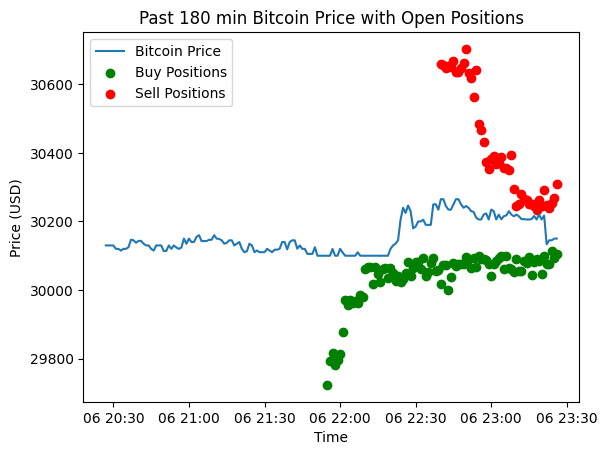

Number of open positions:  139
Number of buy positions:  92
Number of sell positions:  47
Total USDT value of open positions: $ -391.0206000000002
Total BTC value of open positions:  0.013080000000000005
Total at risk value of open positions: $ 3.3412692000000193
Total reward (i.e. if all open positions closed): $ 3.3412691999999993
Sharpe ratio (at the moment):  0.999999999999994
-------------------------
total account value: 1086.1114522867001
Total Inventory Balance (USD): 368.40122996
----------------------------------
price at 12:30am: 30733.14
current BTC inventory: 0.01724933
current USDT inventory: 566.04432528
new hesb value: 1107.1392702762
change of hesb value: % 0.17175091158762992 %
change of hesb value: $ 1.8982615078000435
----------------------------------
same calculation but with current price
current price: 30149.99
new hesb value: 1089.4527214866998
change of hesb value: % -1.428492713936978 %
change of hesb value: $ -15.78828728170015


In [7]:
# plot open positions
# code ran on 12:15 midnight, target 12 midnight to catch all positions

import csv
import matplotlib.pyplot as plt
import ccxt
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json
from Get_balance import get_total_btc, get_total_usdt
from realtime_price_BTCUSDT_call import get_BTCUSDT_realtime_price
import time
import pandas as pd
import numpy as np 
import datetime

X_minutes = 180

api_key = 'ZxOQ7t6879VgwLQzhxIixxB39iIAUX2355YMjFu1yQzDgUmpquOq3Gyb3XESVJBs'
secret_key = 'tjuC6WfLgKNabCbC21KGJq0uF3XjEzvuXVBU1rPuW7FIrbra4IfOfw4pqILLHT5i'
api_url = "https://api.binance.us"

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

uri_path = "/api/v3/openOrders"
data = {
    "timestamp": int(round(time.time() * 1000))
}

result = binanceus_request(uri_path, data, api_key, secret_key)
result = json.loads(result)
# print(json.dumps(result, indent=4))

# Open the file in write mode ('w') and create a CSV writer
with open('open_positions.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write a header row
    writer.writerow(['Quantity', 'Price', 'Side'])

    # Iterate over the result and write each open position to the file
    for position in result:
        quantity = position['origQty']
        price = position['price']
        side = position['side']
        writer.writerow([quantity, price, side])

print("Open positions saved to open_positions.csv")

#######################################################

# Initialize the ccxt exchange
exchange = ccxt.binanceus()
symbol = 'BTC/USDT'

# Fetch past 60 minutes of data
bars = exchange.fetch_ohlcv(symbol, '1m', limit=X_minutes)

# Get closing prices and timestamps
prices = [bar[4] for bar in bars]
timestamps = [bar[0] for bar in bars]

# Convert timestamps to datetime and remove the seconds for cleaner plotting
dates = [datetime.datetime.fromtimestamp(timestamp/1000).replace(second=0, microsecond=0) for timestamp in timestamps]

# Continue with your code...


# Read open positions from file
with open('open_positions.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    positions = list(reader)

# Separate buy and sell positions
buy_positions = [float(pos[1]) for pos in positions if pos[2] == 'BUY']
sell_positions = [float(pos[1]) for pos in positions if pos[2] == 'SELL']

# Create a figure for plotting
fig, ax = plt.subplots()

# Plot the data
ax.plot(dates, prices, label='Bitcoin Price')

# Plot buy and sell positions as scatter plots
if buy_positions:
    ax.scatter(dates[-len(buy_positions):], buy_positions, color='g', label='Buy Positions')
if sell_positions:
    ax.scatter(dates[-len(sell_positions):], sell_positions, color='r', label='Sell Positions')

# Set the title and labels
ax.set_title("Past 180 min Bitcoin Price with Open Positions")
ax.set_xlabel("Time")
ax.set_ylabel("Price (USD)")
# set y axis range
# ax.set_ylim([min(prices) * 0.99, max(prices) * 1.01])

# Show the legend
ax.legend()

# Display the plot
plt.show()

# print number of open positions
print("Number of open positions: ", len(positions))
num_open_positions = len(positions)
# print number of buy positions
print("Number of buy positions: ", len(buy_positions))
# print number of sell positions
print("Number of sell positions: ", len(sell_positions))
# get the last price
last_price = prices[-1]
# calculate risk of open positions (quantity * delta_price)
total_usdt_value = 0
total_btc_value = 0
for position in positions:
    if position[2] == "BUY":
        total_usdt_value -= abs((float(position[1])) * float(position[0]))
        total_btc_value += abs (float(position[0]))
    elif position[2] == "SELL":
        total_usdt_value += abs((float(position[1])) * float(position[0]))
        total_btc_value -= abs (float(position[0]))
# total potential profit that you miss if you close all positions now
print("Total USDT value of open positions: $", total_usdt_value)
print("Total BTC value of open positions: ", total_btc_value)
# save total_value and total_btc_value to csv file
with open('total_value.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([total_usdt_value, total_btc_value])

# calculate total at risk value of open positions
total_at_risk_value = 0
price_at_the_moment = float(prices[-1])
for position in positions:
    if position[2] == "BUY":
        total_at_risk_value += abs(float(price_at_the_moment-float(position[1]))) * float(position[0])
    elif position[2] == "SELL":
        total_at_risk_value += abs(float(price_at_the_moment-float(position[1]))) * float(position[0])
print("Total at risk value of open positions: $", total_at_risk_value)
total_reward = abs((total_btc_value * float(prices[-1]))+total_usdt_value)
print("Total reward (i.e. if all open positions closed): $", total_reward)
sharpe_ratio = total_reward / total_at_risk_value
print("Sharpe ratio (at the moment): ", sharpe_ratio)

print("-------------------------")
moment_price = float(prices[-1])
now = time.time()
total_account_value = get_total_btc()*moment_price+get_total_usdt()
print("total account value:", total_account_value)
main_account_balance_df = pd.read_csv('Deployed_main_account_balance.csv')
print("Total Inventory Balance (USD): " + str(main_account_balance_df.iloc[-1, 0]))
print("----------------------------------")
extra_dollar = 1000
# extra_btc = 0.3255433
price_at_12_30am = 30733.14
# print("extra btc:", extra_dollar/price_at_12_30am)
print("price at 12:30am:", price_at_12_30am)
initial_hesb_value = 105.24100876840001 + 1000
new_hesb_value = (get_total_btc()+total_btc_value)*price_at_12_30am+get_total_usdt()+total_usdt_value
print("current BTC inventory:", get_total_btc())
print("current USDT inventory:", get_total_usdt())
print("new hesb value:", new_hesb_value)
change_of_hesb_value = (new_hesb_value - initial_hesb_value) / initial_hesb_value * 100
print("change of hesb value: %", change_of_hesb_value, "%")
print("change of hesb value: $", new_hesb_value - initial_hesb_value)
print("----------------------------------")
# same calculation but with current price
print("same calculation but with current price")
current_price = get_BTCUSDT_realtime_price()
print("current price:", current_price)
initial_hesb_value = 105.24100876840001 + 1000
new_hesb_value = (get_total_btc()+total_btc_value)*current_price+get_total_usdt()+total_usdt_value
print("new hesb value:", new_hesb_value)
change_of_hesb_value = (new_hesb_value - initial_hesb_value) / initial_hesb_value * 100
print("change of hesb value: %", change_of_hesb_value, "%")
print("change of hesb value: $", new_hesb_value - initial_hesb_value)


In [8]:
# calculate net profit
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json

api_key = 'ZxOQ7t6879VgwLQzhxIixxB39iIAUX2355YMjFu1yQzDgUmpquOq3Gyb3XESVJBs'
secret_key = 'tjuC6WfLgKNabCbC21KGJq0uF3XjEzvuXVBU1rPuW7FIrbra4IfOfw4pqILLHT5i'

api_url = "https://api.binance.us"

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

uri_path = "/api/v3/allOrders"
data = {
    "timestamp": int(round(time.time() * 1000)),
    "symbol": "BTCUSDT",
    "limit": 1000,
}

result = binanceus_request(uri_path, data, api_key, secret_key)

result_obj = json.loads(result)

# print result_obj with 4 indentations
# print(json.dumps(result_obj, indent=4))

# Open the file in write mode ('w') and create a CSV writer
with open('trade_history.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write a header row
    writer.writerow(['Quantity', 'Price', 'Side'])

    # Iterate over the result and write each open position to the file
    for position in result_obj:

        if position['status'] == 'FILLED':
            if position['price'] == '0.00000000':
                price = float(position['cummulativeQuoteQty'])/float(position['executedQty'])
                quantity = float(position['executedQty'])
                side = position['side']
                time_trade = position['time']
                writer.writerow([quantity, price, side, time_trade])
            else: 
                price = float(position['price'])
                quantity = float(position['executedQty'])
                side = position['side']
                time_trade = position['time']
                writer.writerow([quantity, price, side, time_trade])

# print("trade history saved to trade_history.csv")

################################################

# Read trade history from file
with open('trade_history.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    positions = list(reader)

# only work with trades that have been completed in a time period
# get current time
current_time = int(round(time.time() * 1000))
# get 12:30am of July 6th, 2023
time_run = 1688628630000

# get time 24 hours ago
time_24_hours_ago = current_time - 86400000
# get 1.5 hours ago
time_1_5_hours_ago = current_time - 5400000
# get all trades that have been completed in the last 24 hours
completed_trades = []
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    time_trade = int(position[3])
    if time_trade > time_run:
        completed_trades.append(position)

positions = completed_trades

# calculate number of trades
num_trades = len(positions)
print("Number of filled trades: {}".format(num_trades))
# Compute average purchase price
total_purchased = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'BUY':
        total_purchased += quantity * price
avg_purchase_price = total_purchased / num_trades
print("Average purchase price (filled orders): ${}".format(avg_purchase_price))

# Compute average sale price
total_sold = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'SELL':
        total_sold += quantity * price
avg_sale_price = total_sold / num_trades
print("Average sale price (filled orders): ${}".format(avg_sale_price))

# total PnL you miss if you close all open positions
total_risk_open_positions = risk_to_be_copied # read from another file

# real number of full double-trades (SELL-BUY or BUY-SELL)
num_filled_trades = num_trades
num_double_trades = (num_filled_trades - num_open_positions)//2


print("Number of double trades: {}".format(num_double_trades))

# print("num_double_trade*average_sale-purchase_price: {}".format(num_double_trades*(avg_sale_price-avg_purchase_price)))
print("long-term accuracy: {}".format((num_double_trades)/(num_double_trades+num_open_positions)))

Number of filled trades: 849
Average purchase price (filled orders): $1.639129320612485
Average sale price (filled orders): $2.278089656419315


NameError: name 'risk_to_be_copied' is not defined

Changed long ratio to 0.05 (from 0.03) and kept short ratio to 0.01. Started at 11pm

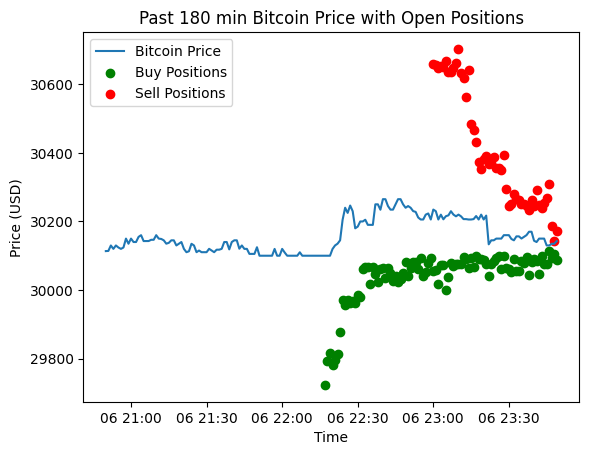

Number of open positions:  143
Number of buy positions:  93
Number of sell positions:  50
Total USDT value of open positions: $ -393.1024483000002
Total BTC value of open positions:  0.013150000000000007
Total at risk value of open positions: $ 3.274714199999997
Total reward (i.e. if all open positions closed): $ 3.2747142000000053
Sharpe ratio (at the moment):  1.0000000000000027
----------------------------------
total account value: 1085.9862257375
Total Inventory Balance (USD): 393.0455749372
----------------------------------
price at 12:30am: 30733.14
current BTC inventory: 0.01717933
current USDT inventory: 568.15397638
new hesb value: 1107.1670730762003
change of account value: % 0.17426645342689143 %
change of account value: $ 1.9260643078002886
----------------------------------
Number of filled trades: 845
Average purchase price (filled orders): $1.6621475008284023
Average sale price (filled orders): $2.3065972111242585
Number of double trades: 351
long-term accuracy: 0.7105

In [16]:
# plot open positions
# code ran on 12:15 midnight, target 12 midnight to catch all positions

import csv
import matplotlib.pyplot as plt
import ccxt
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json
from Get_balance import get_total_btc, get_total_usdt
from realtime_price_BTCUSDT_call import get_BTCUSDT_realtime_price
import time
import pandas as pd
import numpy as np 
import datetime

X_minutes = 180

api_key = 'ZxOQ7t6879VgwLQzhxIixxB39iIAUX2355YMjFu1yQzDgUmpquOq3Gyb3XESVJBs'
secret_key = 'tjuC6WfLgKNabCbC21KGJq0uF3XjEzvuXVBU1rPuW7FIrbra4IfOfw4pqILLHT5i'
api_url = "https://api.binance.us"

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

uri_path = "/api/v3/openOrders"
data = {
    "timestamp": int(round(time.time() * 1000))
}

result = binanceus_request(uri_path, data, api_key, secret_key)
result = json.loads(result)
# print(json.dumps(result, indent=4))

# Open the file in write mode ('w') and create a CSV writer
with open('open_positions.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write a header row
    writer.writerow(['Quantity', 'Price', 'Side'])

    # Iterate over the result and write each open position to the file
    for position in result:
        quantity = position['origQty']
        price = position['price']
        side = position['side']
        writer.writerow([quantity, price, side])

# print("Open positions saved to open_positions.csv")

#######################################################

# Initialize the ccxt exchange
exchange = ccxt.binanceus()
symbol = 'BTC/USDT'

# Fetch past 60 minutes of data
bars = exchange.fetch_ohlcv(symbol, '1m', limit=X_minutes)

# Get closing prices and timestamps
prices = [bar[4] for bar in bars]
timestamps = [bar[0] for bar in bars]

# Convert timestamps to datetime and remove the seconds for cleaner plotting
dates = [datetime.datetime.fromtimestamp(timestamp/1000).replace(second=0, microsecond=0) for timestamp in timestamps]

# Continue with your code...


# Read open positions from file
with open('open_positions.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    positions = list(reader)

# Separate buy and sell positions
buy_positions = [float(pos[1]) for pos in positions if pos[2] == 'BUY']
sell_positions = [float(pos[1]) for pos in positions if pos[2] == 'SELL']

# Create a figure for plotting
fig, ax = plt.subplots()

# Plot the data
ax.plot(dates, prices, label='Bitcoin Price')

# Plot buy and sell positions as scatter plots
if buy_positions:
    ax.scatter(dates[-len(buy_positions):], buy_positions, color='g', label='Buy Positions')
if sell_positions:
    ax.scatter(dates[-len(sell_positions):], sell_positions, color='r', label='Sell Positions')

# Set the title and labels
ax.set_title("Past 180 min Bitcoin Price with Open Positions")
ax.set_xlabel("Time")
ax.set_ylabel("Price (USD)")
# set y axis range
# ax.set_ylim([min(prices) * 0.99, max(prices) * 1.01])

# Show the legend
ax.legend()

# Display the plot
plt.show()

# print number of open positions
print("Number of open positions: ", len(positions))
num_open_positions = len(positions)
# print number of buy positions
print("Number of buy positions: ", len(buy_positions))
# print number of sell positions
print("Number of sell positions: ", len(sell_positions))
# get the last price
last_price = prices[-1]
# calculate risk of open positions (quantity * delta_price)
total_usdt_value = 0
total_btc_value = 0
for position in positions:
    if position[2] == "BUY":
        total_usdt_value -= abs((float(position[1])) * float(position[0]))
        total_btc_value += abs (float(position[0]))
    elif position[2] == "SELL":
        total_usdt_value += abs((float(position[1])) * float(position[0]))
        total_btc_value -= abs (float(position[0]))
# total potential profit that you miss if you close all positions now
print("Total USDT value of open positions: $", total_usdt_value)
print("Total BTC value of open positions: ", total_btc_value)
# save total_value and total_btc_value to csv file
with open('total_value.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([total_usdt_value, total_btc_value])

# calculate total at risk value of open positions
total_at_risk_value = 0
price_at_the_moment = float(prices[-1])
for position in positions:
    if position[2] == "BUY":
        total_at_risk_value += abs(float(price_at_the_moment-float(position[1]))) * float(position[0])
    elif position[2] == "SELL":
        total_at_risk_value += abs(float(price_at_the_moment-float(position[1]))) * float(position[0])
print("Total at risk value of open positions: $", total_at_risk_value)
total_reward = abs((total_btc_value * float(prices[-1]))+total_usdt_value)
print("Total reward (i.e. if all open positions closed): $", total_reward)
sharpe_ratio = total_reward / total_at_risk_value
print("Sharpe ratio (at the moment): ", sharpe_ratio)
print("----------------------------------")
moment_price = float(prices[-1])
now = time.time()
total_account_value = get_total_btc()*moment_price+get_total_usdt()
print("total account value:", total_account_value)
main_account_balance_df = pd.read_csv('Deployed_main_account_balance.csv')
print("Total Inventory Balance (USD): " + str(main_account_balance_df.iloc[-1, 0]))
print("----------------------------------")
extra_dollar = 1000
# extra_btc = 0.3255433
price_at_12_30am = 30733.14
# print("extra btc:", extra_dollar/price_at_12_30am)
print("price at 12:30am:", price_at_12_30am)
initial_hesb_value = 105.24100876840001 + 1000
new_hesb_value = (get_total_btc()+total_btc_value)*price_at_12_30am+get_total_usdt()+total_usdt_value
print("current BTC inventory:", get_total_btc())
print("current USDT inventory:", get_total_usdt())
print("new hesb value:", new_hesb_value)
change_of_hesb_value = (new_hesb_value - initial_hesb_value) / initial_hesb_value * 100
print("change of account value: %", change_of_hesb_value, "%")
print("change of account value: $", new_hesb_value - initial_hesb_value)
print("----------------------------------")
# same calculation but with current price
# print("same calculation but with current price")
# current_price = get_BTCUSDT_realtime_price()
# print("current price:", current_price)
# initial_hesb_value = 105.24100876840001 + 1000
# new_hesb_value = (get_total_btc()+total_btc_value)*current_price+get_total_usdt()+total_usdt_value
# print("new hesb value:", new_hesb_value)
# change_of_hesb_value = (new_hesb_value - initial_hesb_value) / initial_hesb_value * 100
# print("change of hesb value: %", change_of_hesb_value, "%")
# print("change of hesb value: $", new_hesb_value - initial_hesb_value)
# calculate net profit

##############################################
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json

api_key = 'ZxOQ7t6879VgwLQzhxIixxB39iIAUX2355YMjFu1yQzDgUmpquOq3Gyb3XESVJBs'
secret_key = 'tjuC6WfLgKNabCbC21KGJq0uF3XjEzvuXVBU1rPuW7FIrbra4IfOfw4pqILLHT5i'

api_url = "https://api.binance.us"

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

uri_path = "/api/v3/allOrders"
data = {
    "timestamp": int(round(time.time() * 1000)),
    "symbol": "BTCUSDT",
    "limit": 1000,
}

result = binanceus_request(uri_path, data, api_key, secret_key)

result_obj = json.loads(result)

# print result_obj with 4 indentations
# print(json.dumps(result_obj, indent=4))

# Open the file in write mode ('w') and create a CSV writer
with open('trade_history.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write a header row
    writer.writerow(['Quantity', 'Price', 'Side'])

    # Iterate over the result and write each open position to the file
    for position in result_obj:

        if position['status'] == 'FILLED':
            if position['price'] == '0.00000000':
                price = float(position['cummulativeQuoteQty'])/float(position['executedQty'])
                quantity = float(position['executedQty'])
                side = position['side']
                time_trade = position['time']
                writer.writerow([quantity, price, side, time_trade])
            else: 
                price = float(position['price'])
                quantity = float(position['executedQty'])
                side = position['side']
                time_trade = position['time']
                writer.writerow([quantity, price, side, time_trade])

# print("trade history saved to trade_history.csv")

################################################

# Read trade history from file
with open('trade_history.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    positions = list(reader)

# only work with trades that have been completed in a time period
# get current time
current_time = int(round(time.time() * 1000))
# get 12:30am of July 6th, 2023
time_run = 1688628630000

# get time 24 hours ago
time_24_hours_ago = current_time - 86400000
# get 1.5 hours ago
time_1_5_hours_ago = current_time - 5400000
# get all trades that have been completed in the last 24 hours
completed_trades = []
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    time_trade = int(position[3])
    if time_trade > time_run:
        completed_trades.append(position)

positions = completed_trades

# calculate number of trades
num_trades = len(positions)
print("Number of filled trades: {}".format(num_trades))
# Compute average purchase price
total_purchased = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'BUY':
        total_purchased += quantity * price
avg_purchase_price = total_purchased / num_trades
print("Average purchase price (filled orders): ${}".format(avg_purchase_price))

# Compute average sale price
total_sold = 0
for position in positions:
    quantity = float(position[0])
    price = float(position[1])
    side = position[2]
    if side == 'SELL':
        total_sold += quantity * price
avg_sale_price = total_sold / num_trades
print("Average sale price (filled orders): ${}".format(avg_sale_price))

# real number of full double-trades (SELL-BUY or BUY-SELL)
num_filled_trades = num_trades
num_double_trades = (num_filled_trades - num_open_positions)//2


print("Number of double trades: {}".format(num_double_trades))

# print("num_double_trade*average_sale-purchase_price: {}".format(num_double_trades*(avg_sale_price-avg_purchase_price)))
print("long-term accuracy: {}".format((num_double_trades)/(num_double_trades+num_open_positions)))